# Парадокс дней рождения

## Постановка задачи

Казалось бы, чтобы с вероятностью более 50% найти двух людей с одинаковым днём рождения (число и месяц), нужно собрать около 183 человек (половина от 365). Однако это не так!

## Формулировка парадокса

В группе из всего 23 случайно выбранных людей вероятность совпадения дней рождения хотя бы у двух из них превышает 50%.

В группе же из 57 человек эта вероятность уже превышает 99%.

Это кажется невероятным, но это строгий математический факт.

## Интуитивное объяснение

Заблуждение возникает из-за того, что люди думаю о вероятности совпадения дня рождения с **конкретным человеком**. На самом деле нужно учитывать **все возможные пары** в группе.

В группе из n человек количество возможных пар: $$C_n^2 = \frac {n(n-1)} {2}$$

Для 23 человек: $\frac {23 * 22} {2} = 253$ пары. Каждая пара даёт шанс на совпадение.

## Код

### Импорт библиотек

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from math import comb, factorial
from collections import Counter
import seaborn as sns

sns.set_style("whitegrid")

Вероятность того, что все дни рождения различны в группе из n человек (при 365 днях в году): $$P(\text{Все различны}) = \frac {365} {365} * \frac {364} {365} * \frac {363} {365} * ... * \frac {365 - n + 1} {365}$$
$$P(\text{Все различны}) = \frac {365!} {(365 - n)! * 365^n}$$

Тогда вероятность хотя бы одного совпадения: $$P(\text{Совпадение}) = 1 - P(\text{Все различны})$$

### Теоретический расчёт вероятности

In [2]:
def theoretical_probability(n, days=365):
    """
    Вычисляет теоретическую вероятность совпадения дней рождения 
    хотя бы у двух человек в группе из n человек.
    """
    if n > days:
        return 1.0
    
    prob_all_different = 1.0
    for i in range(n):
        prob_all_different *= (days - i) / days
    
    return 1 - prob_all_different

# Создаем массив значений для n от 1 до 80
n_values = list(range(1, 81))
theoretical_probs = [theoretical_probability(n) for n in n_values]

# Находим минимальное n, где вероятность > 50%
threshold_50 = next(n for n, p in zip(n_values, theoretical_probs) if p > 0.5)
threshold_95 = next(n for n, p in zip(n_values, theoretical_probs) if p > 0.95)
threshold_99 = next(n for n, p in zip(n_values, theoretical_probs) if p > 0.99)

print("="*60)
print("ТЕОРЕТИЧЕСКИЕ РЕЗУЛЬТАТЫ")
print("="*60)
print(f"Минимальный размер группы для вероятности > 50%: {threshold_50} человек")
print(f"Вероятность при n={threshold_50}: {theoretical_probability(threshold_50):.4f} ({theoretical_probability(threshold_50)*100:.2f}%)")
print()
print(f"Минимальный размер группы для вероятности > 95%: {threshold_95} человек")
print(f"Минимальный размер группы для вероятности > 99%: {threshold_99} человек")
print()
print(f"Вероятность для 23 человек: {theoretical_probability(23):.4f} ({theoretical_probability(23)*100:.2f}%)")
print(f"Вероятность для 30 человек: {theoretical_probability(30):.4f} ({theoretical_probability(30)*100:.2f}%)")
print(f"Вероятность для 50 человек: {theoretical_probability(50):.4f} ({theoretical_probability(50)*100:.2f}%)")
print("="*60)

ТЕОРЕТИЧЕСКИЕ РЕЗУЛЬТАТЫ
Минимальный размер группы для вероятности > 50%: 23 человек
Вероятность при n=23: 0.5073 (50.73%)

Минимальный размер группы для вероятности > 95%: 47 человек
Минимальный размер группы для вероятности > 99%: 57 человек

Вероятность для 23 человек: 0.5073 (50.73%)
Вероятность для 30 человек: 0.7063 (70.63%)
Вероятность для 50 человек: 0.9704 (97.04%)


### Моделирование

In [4]:
def simulate_one_group(n, days=365, max_duplicates=False):
    """
    Моделирует одну группу из n человек.
    Возвращает True, если есть хотя бы одно совпадение дней рождения.
    Если max_duplicates=True, возвращает максимальное количество совпадений.
    """
    birthdays = [random.randint(1, days) for _ in range(n)]
    
    if max_duplicates:
        counts = Counter(birthdays)
        return max(counts.values()) if counts else 1
    else:
        return len(set(birthdays)) < n  # True если есть совпадения

def monte_carlo_simulation(n, trials=10000):
    """
    Проводит серию экспериментов для группы из n человек.
    """
    successes = 0
    max_duplicates_list = []
    
    for _ in range(trials):
        result = simulate_one_group(n, max_duplicates=False)
        if result:
            successes += 1
        
        # Для анализа максимальных совпадений
        max_dup = simulate_one_group(n, max_duplicates=True)
        max_duplicates_list.append(max_dup)
    
    empirical_prob = successes / trials
    avg_max_duplicates = np.mean(max_duplicates_list)
    
    return empirical_prob, avg_max_duplicates, max_duplicates_list

# Проводим симуляцию для разных размеров групп
group_sizes = [5, 10, 15, 20, 23, 25, 30, 40, 50, 60]
results = []

print("Моделирование (10,000 испытаний для каждого n)")
print("="*70)
print(f"{'n':>4} | {'Теор. вер.':>12} | {'Эксп. вер.':>12} | {'Разница':>10} | {'Ср. макс. повт.':>15}")
print("-"*70)

for n in group_sizes:
    theoretical = theoretical_probability(n)
    empirical, avg_max_dup, _ = monte_carlo_simulation(n, trials=10000)
    diff = abs(theoretical - empirical)
    
    results.append((n, theoretical, empirical, avg_max_dup))
    print(f"{n:4d} | {theoretical:12.4f} | {empirical:12.4f} | {diff:10.4f} | {avg_max_dup:15.2f}")

print("="*70)

Моделирование (10,000 испытаний для каждого n)
   n |   Теор. вер. |   Эксп. вер. |    Разница | Ср. макс. повт.
----------------------------------------------------------------------
   5 |       0.0271 |       0.0302 |     0.0031 |            1.03
  10 |       0.1169 |       0.1168 |     0.0001 |            1.12
  15 |       0.2529 |       0.2499 |     0.0030 |            1.25
  20 |       0.4114 |       0.4060 |     0.0054 |            1.42
  23 |       0.5073 |       0.5053 |     0.0020 |            1.51
  25 |       0.5687 |       0.5628 |     0.0059 |            1.59
  30 |       0.7063 |       0.7049 |     0.0014 |            1.74
  40 |       0.8912 |       0.8966 |     0.0054 |            1.96
  50 |       0.9704 |       0.9704 |     0.0000 |            2.10
  60 |       0.9941 |       0.9938 |     0.0003 |            2.21


### Визуализация - график парадокса

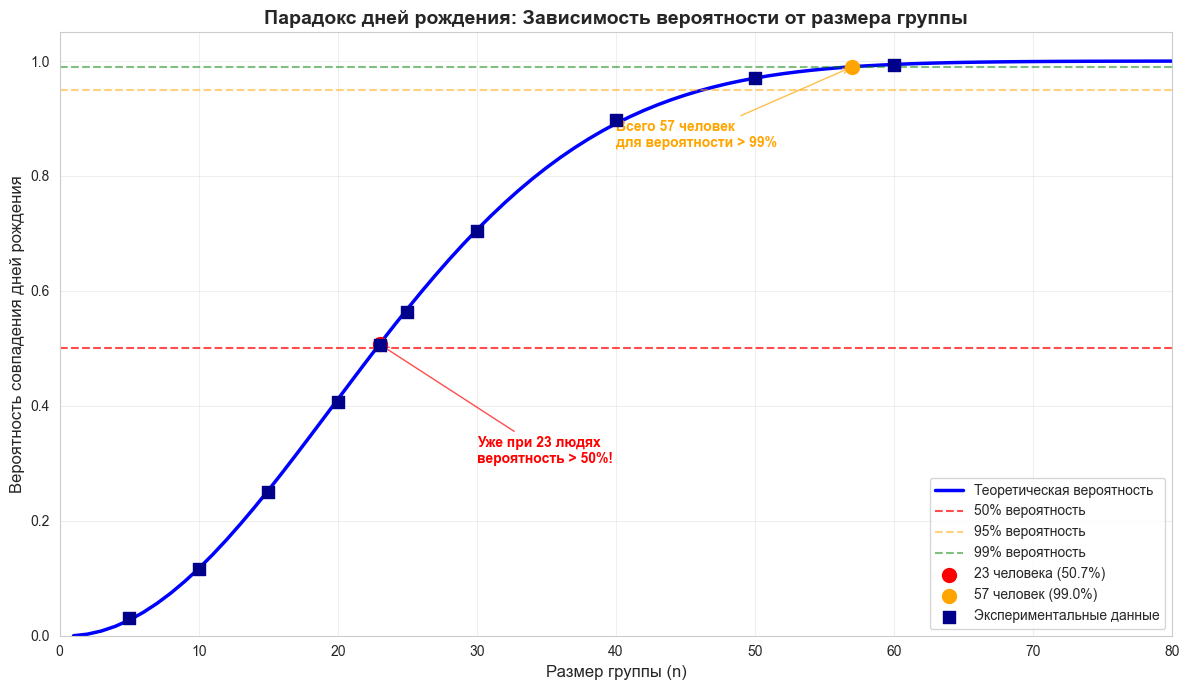

In [5]:
plt.figure(figsize=(12, 7))

# График теоретической вероятности
plt.plot(n_values, theoretical_probs, 'b-', linewidth=2.5, label='Теоретическая вероятность')

# Добавляем горизонтальные линии и точки
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='50% вероятность')
plt.axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95% вероятность')
plt.axhline(y=0.99, color='green', linestyle='--', alpha=0.5, label='99% вероятность')

# Отмечаем ключевые точки
plt.scatter([23], [theoretical_probability(23)], color='red', s=100, zorder=5, 
            label=f'23 человека ({theoretical_probability(23)*100:.1f}%)')
plt.scatter([57], [theoretical_probability(57)], color='orange', s=100, zorder=5,
            label=f'57 человек ({theoretical_probability(57)*100:.1f}%)')

# Добавляем эмпирические точки из симуляции
empirical_n = [r[0] for r in results]
empirical_probs = [r[2] for r in results]
plt.scatter(empirical_n, empirical_probs, color='darkblue', s=80, marker='s', 
            zorder=5, label='Экспериментальные данные')

plt.xlabel('Размер группы (n)', fontsize=12)
plt.ylabel('Вероятность совпадения дней рождения', fontsize=12)
plt.title('Парадокс дней рождения: Зависимость вероятности от размера группы', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 80)
plt.ylim(0, 1.05)

# Добавляем текстовые аннотации
plt.annotate('Уже при 23 людях\nвероятность > 50%!', 
             xy=(23, theoretical_probability(23)), 
             xytext=(30, 0.3),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, color='red', fontweight='bold')

plt.annotate('Всего 57 человек\nдля вероятности > 99%', 
             xy=(57, theoretical_probability(57)), 
             xytext=(40, 0.85),
             arrowprops=dict(arrowstyle='->', color='orange', alpha=0.7),
             fontsize=10, color='orange', fontweight='bold')

plt.tight_layout()
plt.show()

## Почему это парадокс

Интуитивная ошибка. Люди путают два вопроса:
- Какова вероятность, что у кого-то день рождения совпадает с моим?
- Какова вероятность, что среди всех пар в группе найдётся совпадение? - **вероятность значительно больше**

Парадокс дней рождения - прекрасный пример того, как человеческая интуиция может подводить нас в вопросах вероятности